In [1]:
import geopandas as gpd
import joblib
import numpy as np
import odc.geo.xr  # noqa: F401
import pandas as pd
import xarray as xr
from odc.stac import load
from pystac_client import Client
from shapely import geometry
from sklearn.ensemble import RandomForestClassifier
from dask.distributed import Client as dask_client
from depal_fj import get_image_values
import depal_fj as dep

In [2]:
%reload_ext autoreload
%autoreload 2

## Load study area

Load data and set up your array to use for prediction

In [3]:
# Configure some things up front
chunks = dict(x=100, y=100)
datetime = "2023"

aoi = dep.get_island("Kadavu")
bbox = dep.get_bbox(aoi)
bbox_geometry = geometry.box(*bbox)

gdf = gpd.GeoDataFrame({'geometry': [bbox_geometry]}, crs='EPSG:4326')
gdf.explore()

In [4]:
catalog = "https://stac.staging.digitalearthpacific.org"
client = Client.open(catalog)

# Search for Sentinel-2 GeoMAD data
items = client.search(
    collections=["dep_s2_geomad"],
    bbox=bbox,
    datetime=datetime
).items()

# Load the data
data = load(items, chunks=chunks, bbox=bbox).squeeze("time")
data


<xarray.Dataset>
Dimensions:      (y: 2719, x: 5944)
Coordinates:
  * y            (y) float64 -2.133e+06 -2.133e+06 ... -2.16e+06 -2.16e+06
  * x            (x) float64 3.112e+06 3.112e+06 ... 3.171e+06 3.171e+06
    spatial_ref  int32 3832
    time         datetime64[ns] 2023-01-01
Data variables: (12/14)
    B02          (y, x) float32 dask.array<chunksize=(100, 100), meta=np.ndarray>
    B03          (y, x) float32 dask.array<chunksize=(100, 100), meta=np.ndarray>
    B04          (y, x) float32 dask.array<chunksize=(100, 100), meta=np.ndarray>
    B05          (y, x) float32 dask.array<chunksize=(100, 100), meta=np.ndarray>
    B06          (y, x) float32 dask.array<chunksize=(100, 100), meta=np.ndarray>
    B07          (y, x) float32 dask.array<chunksize=(100, 100), meta=np.ndarray>
    ...           ...
    B12          (y, x) float32 dask.array<chunksize=(100, 100), meta=np.ndarray>
    B8A          (y, x) float32 dask.array<chunksize=(100, 100), meta=np.ndarray>
    emad         (y, x) float32 dask.array<chunksize=(100, 100), meta=np.ndarray>
    smad         (y, x) float32 dask.array<chunksize=(100, 100), meta=np.ndarray>
    bcmad        (y, x) float32 dask.array<chunksize=(100, 100), meta=np.ndarray>
    count        (y, x) float32 dask.array<chunksize=(100, 100), meta=np.ndarray>

In [5]:
training_file = "Fiji/fj_lulc_data_points_merged.gpkg"

training_data = gpd.read_file(training_file, bbox=bbox_geometry)
training_data.explore(
    tiles="https://server.arcgisonline.com/ArcGIS/rest/services/World_Imagery/MapServer/tile/{z}/{y}/{x}",
    attr="Esri",
    name="Esri Satellite",
    column="Class"
)

<Axes: xlabel='Class'>

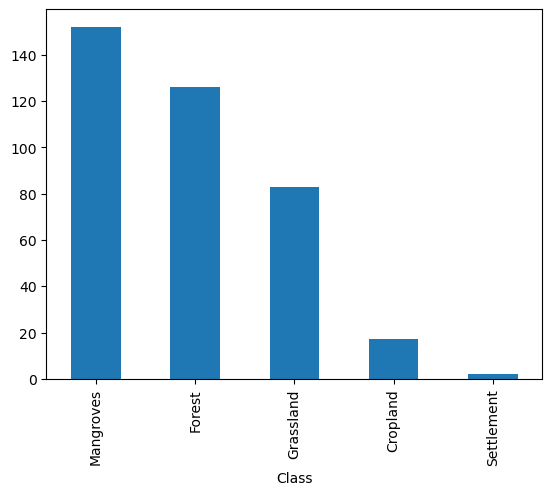

In [6]:
# Count the values in a specific column (e.g., "Class" column)
class_counts = training_data['Class'].value_counts()

# Display the counts
class_counts.plot.bar()

In [7]:
# Subset the training data to a smaller sample size, if required
#subset = training_data.sample(1000)
subset = training_data

with dask_client(
    n_workers=16, threads_per_worker=16, memory_limit="10GB"
):
    variables = get_image_values(subset, data)

variables.head()

,y,x,spatial_ref,time,B02,B03,B04,B05,B06,B07,B08,B11,B12,B8A,emad,smad,bcmad,count
index,,,,,,,,,,,,,,,,,,
0,-2156855.0,3111625.0,3832,2023-01-01,979.0,1096.0,572.0,589.0,432.0,509.0,307.0,362.0,230.0,503.0,846.776001,0.015385,0.228949,53.0
1,-2155415.0,3113045.0,3832,2023-01-01,682.0,1200.0,523.0,1860.0,5509.0,6403.0,6206.0,2952.0,1472.0,6605.0,1608.950195,0.001147,0.064670,58.0
2,-2156845.0,3113055.0,3832,2023-01-01,473.0,543.0,397.0,674.0,1646.0,2073.0,1868.0,903.0,453.0,2212.0,1228.291748,0.006480,0.141542,58.0
3,-2153975.0,3114465.0,3832,2023-01-01,538.0,857.0,507.0,1364.0,4028.0,5044.0,4983.0,2078.0,1013.0,5427.0,1558.502563,0.001617,0.093803,54.0
4,-2155405.0,3114475.0,3832,2023-01-01,458.0,600.0,385.0,900.0,2907.0,3763.0,3850.0,1452.0,716.0,4115.0,2259.130371,0.003887,0.137092,38.0


In [8]:
# Sort the variables by name, so they're in a consistent order
sorted_variables = variables.sort_index(axis=1)

# Join the new variables to the original points and drop non-required columns
training_array = pd.concat([training_data["ClassId"], sorted_variables], axis=1)
training_array = training_array.drop(columns=['time','x','y','spatial_ref'])

# Drop rows where there are any NaNs
training_array = training_array.dropna()

# Explore our data
training_array.head()

,ClassId,B02,B03,B04,B05,B06,B07,B08,B11,B12,B8A,bcmad,count,emad,smad
0,2,979.0,1096.0,572.0,589.0,432.0,509.0,307.0,362.0,230.0,503.0,0.228949,53.0,846.776001,0.015385
1,3,682.0,1200.0,523.0,1860.0,5509.0,6403.0,6206.0,2952.0,1472.0,6605.0,0.064670,58.0,1608.950195,0.001147
2,1,473.0,543.0,397.0,674.0,1646.0,2073.0,1868.0,903.0,453.0,2212.0,0.141542,58.0,1228.291748,0.006480
3,2,538.0,857.0,507.0,1364.0,4028.0,5044.0,4983.0,2078.0,1013.0,5427.0,0.093803,54.0,1558.502563,0.001617
4,2,458.0,600.0,385.0,900.0,2907.0,3763.0,3850.0,1452.0,716.0,4115.0,0.137092,38.0,2259.130371,0.003887


In [9]:
classifier = RandomForestClassifier(
    n_estimators=100,
    max_depth=10,
    min_samples_leaf=10,
    n_jobs=-1,
    random_state=42,
)

training_data = np.array(training_array)[:, 1:]
classes = np.array(training_array)[:, 0]

model = classifier.fit(training_data, classes)

In [10]:
# Print feature importances against column headings
fields_importances = sorted(
    zip(training_array.columns[1:], classifier.feature_importances_),
    key=lambda x: x[1],
    reverse=True,
)

for i in fields_importances:
    # Format as a table to 2 decinal places
    print(f"{i[0]:<11}| {i[1]:.2f}")


B12        | 0.26
B11        | 0.24
B02        | 0.09
B05        | 0.07
B8A        | 0.06
B03        | 0.05
B08        | 0.04
B04        | 0.04
B07        | 0.03
B06        | 0.03
count      | 0.02
emad       | 0.02
bcmad      | 0.02
smad       | 0.01


## Export the model for use in the prediction notebook

In [11]:
joblib.dump(model, "fj_lulc.model")

['fj_lulc.model']

In [12]:
print("Model Trained.")

Model Trained.
